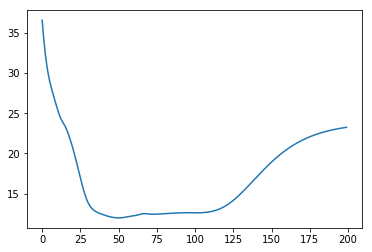

min loss = 11.9653407358


In [2]:
# -*- coding: utf-8 -*-
"""
Created on Tue Sep 12 20:39:09 2017

"""
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_boston
from sklearn.preprocessing import normalize
import scipy
np.random.seed(0)

# load boston housing prices dataset
boston = load_boston()
x = boston['data']
N = x.shape[0]
x = np.concatenate((np.ones((506,1)),x),axis=1) #add constant one feature - no bias needed
d = x.shape[1]
y = boston['target']

idx = np.random.permutation(range(N))

# http://www.cs.toronto.edu/~jlucas/teaching/csc411/hw/assignment1/hw1.pdf
# Answer for: Locally reweighted regression

def l2(A,B):
    '''
    Input: A is a Nxd matrix
           B is a Mxd matirx
    Output: dist is a NxM matrix where dist[i,j] is the square norm between A[i,:] and B[j,:]
    i.e. dist[i,j] = ||A[i,:]-B[j,:]||^2
    '''
    A_norm = (A**2).sum(axis=1).reshape(A.shape[0],1)
    B_norm = (B**2).sum(axis=1).reshape(1,B.shape[0])
    dist = A_norm+B_norm-2*A.dot(B.transpose())
    return dist

def run_on_fold(x_test, y_test, x_train, y_train, taus):
    '''
    Input: x_test is the N_test x d design matrix
           y_test is the N_test x 1 targets vector        
           x_train is the N_train x d design matrix
           y_train is the N_train x 1 targets vector
           taus is a vector of tau values to evaluate
    output: losses a vector of average losses one for each tau value
    '''
    N_test = x_test.shape[0]
    losses = np.zeros(taus.shape)
    for j,tau in enumerate(taus):
        predictions =  np.array([LRLS(x_test[i,:].reshape(d,1),x_train,y_train, tau) \
                        for i in range(N_test)])
        losses[j] = ((predictions.flatten()-y_test.flatten())**2).mean()
    return losses
 
def LRLS(test_datum, x_train, y_train, tau, lam=1e-5):
    '''
    Input: test_datum is a dx1 test vector
           x_train is the N_train x d design matrix
           y_train is the N_train x 1 targets vector
           tau is the local reweighting parameter
           lam is the regularization parameter
    output is y_hat the prediction on test_datum
    '''
    
    test_datum = test_datum.T
    tau_squared_double = 2*(tau**2)

    negative_l2_by_local_reweight = -l2(test_datum, x_train)/tau_squared_double
    l2_by_tau_max = negative_l2_by_local_reweight.max()
    
    numerator = negative_l2_by_local_reweight
    
    dominator = scipy.misc.logsumexp(negative_l2_by_local_reweight)

#     Normalize and handle underflow/overflow 
    A = np.exp(numerator - dominator)
    A = np.diag(A[0])
    xt_a_x = np.dot(np.dot(x_train.T, A), x_train)
    xt_a_x_plus_lam_identity = xt_a_x + np.dot(lam, np.identity(d))
    to_zero_derivative = np.dot(np.dot(x_train.T, A), y_train.T)
    weights = np.linalg.solve(xt_a_x_plus_lam_identity, to_zero_derivative)
    y_hat = np.dot(test_datum, weights)
    
    return y_hat



def run_k_fold(x, y, taus, k):
    '''
    Input: x is the N x d design matrix
           y is the N x 1 targets vector    
           taus is a vector of tau values to evaluate
           K in the number of folds
    output is losses a vector of k-fold cross validation losses one for each tau value
    '''
    
    losses_per_folds = []
    
#     k number of folds
    for i in xrange(k):
        range_i = i*(N/k)
        range_i_end = (i+1)*(N/k)     
        if i == k-1:
            test_x_fold = x[range_i:]
            test_y_fold = y[range_i:]
        else:
            test_x_fold = x[range_i:range_i_end]
            test_y_fold = y[range_i:range_i_end]
    
        train_x_fold = np.concatenate((x[0:range_i], x[range_i_end:]), axis=0)
        train_y_fold = np.concatenate((y[0:range_i], y[range_i_end:]), axis=0)
        
        fold_losses = run_on_fold(test_x_fold, test_y_fold, train_x_fold, train_y_fold, taus)
        losses_per_folds.append(fold_losses)
        
    average_tau_values = np.mean(losses_per_folds, axis=0)
    
    return average_tau_values


if __name__ == "__main__":
    # In this excersice we fixed lambda (hard coded to 1e-5) and only set tau value. Feel free to play with lambda as well if you wish
    taus = np.logspace(1.0, 3, 200)
    
    # x and y values set to random indices to set a random partitioning by default.
    losses = run_k_fold(x[idx], y[idx], taus, k=5)
    plt.plot(losses)
    plt.show()
    print("min loss = {}".format(losses.min()))
    #     min loss = 11.96
